# [WSI] Ćwiczenie nr 1
Mikołaj Wewiór 318407

In [101]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm


DIMENSIONS = 2


def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


In [102]:
class Function:

    def __init__(self, bounds, dimensions, beta, initial_position, global_optimum=0.0):
        self._name = None
        self._bounds = bounds
        self._dimensions = dimensions
        self._beta = beta
        self._current_position = initial_position
        self._global_optimum = global_optimum


    def name(self):
        return self._name


    def d(self):
        return self._dimensions


    def bounds(self):
        return self._bounds


    def position(self):
        return self._current_position


    def set_position(self, new_position):
        self._current_position = new_position


    def beta(self):
        return self._beta


    def set_beta(self, new_beta):
        self._beta = new_beta


    def global_optimum(self):
        return self._global_optimum


    def grad(self, x_vector, i):
        return None


    def update_position(self):
        min_bound = self._bounds[0]
        max_bound = self._bounds[1]
        d = self.d()
        x = copy.deepcopy(self.position())

        for i in range(d):
            upd = self.beta()*self.grad(x, i)
            x[i] = x[i] - upd

            while x[i] > max_bound:
                diff = x[i] - max_bound
                x[i] = min_bound + diff
            while x[i] < min_bound:
                diff = x[i] - min_bound
                x[i] = max_bound + diff

        self.set_position(x)
        return x


In [103]:
class Rastrigin(Function):

    def __init__(self, bounds, dimensions, beta, initial_position):
        super().__init__(bounds, dimensions, beta, initial_position)
        self._name = "Rastrigin"


    def q(self, x_vector):
        d = self._dimensions
        partial_cost = lambda x: x**2 - 10*np.cos(2*np.pi*x)

        cost = 10*d
        for i in range(d) : cost += partial_cost(x_vector[i])

        return cost


    def grad(self, x_vector, i):
        x = x_vector[i]
        gradient = 2*x +20*np.pi*np.sin(2*np.pi*x)
        return gradient


In [104]:
class Griewank(Function):

    def __init__(self, bounds, dimensions, beta, initial_position):
        super().__init__(bounds, dimensions, beta, initial_position)
        self._name = "Griewank"


    def q(self, x_vector):
        d = self._dimensions

        SUM = 0
        for i in range(d):
            SUM += x_vector[i]**2
        SUM = SUM / 4000

        PI = 1
        for i in range(d):
            PI = PI*np.cos(
                x_vector[i]*np.sqrt(i+1)/(i+1)
            )

        return SUM - PI + 1


    def grad(self, x_vector, i):
        x = x_vector
        PI_rest = 1
        for j in range(self.d()):
            if j != i:
                PI_rest = PI_rest*np.cos(
                    x[j]*np.sqrt(j+1)/(j+1)
                )

        return x[i]/2000 + np.sin(x[i]*np.sqrt(i+1)/(i+1)) * PI_rest*np.sqrt(i+1)/(i+1)


In [105]:
class Test:

    def __init__(self, max_iterations, function, epsilon=None):
        self._max_iterations = max_iterations
        self._last_iteration = max_iterations
        self._function = function
        self._epsilon = epsilon
        self._routes = None


    def max_interations(self):
        return self._max_iterations


    def function(self):
        return self._function


    def initial_position(self):
        return self.function().position()


    def set_routes(self, routes):
        self._routes = routes


    def get_routes(self):
        return self._routes


    def set_last_iteration(self, iteration_id):
        self._last_iteration = iteration_id


    def get_last_iteration(self):
        return self._last_iteration


    def epsilon(self):
        return self._epsilon


    def close_enough(self, last_qs):
        if len(last_qs) < 3:
            return False
        if abs(last_qs[-1] - last_qs[-2]) < self.epsilon():
            return True
        return False


    def break_faster(self, route_q, t):
        if self.epsilon() is not None:
            if self.close_enough(route_q):
                self.set_last_iteration(t)
                return True
        return False


    def do_test(self):
        this_func = self.function()
        route_x = []
        route_y = []
        route_q = []

        for t in range(self.max_interations()):
            x = this_func.position()
            q = this_func.q(x)
            route_x.append(x[0])
            route_y.append(x[1])
            route_q.append(q)
            this_func.update_position()

            if self.break_faster(route_q, t):
                break

        self.set_routes([route_x, route_y, route_q])

        return route_x, route_y, route_q


In [106]:
class Plotter:
    def __init__(self, dimensions, steps, function, bounds=None):
        self._dimensions = dimensions
        self._steps = steps
        self._function = function
        self._bounds = bounds


    def funciton(self):
        return self._function


    def name(self):
        return self.funciton().name()


    def d(self):
        return self._dimensions


    def steps(self):
        return self._steps


    def bounds(self):
        if self._bounds != None:
            return self._bounds
        return self.funciton().bounds()


    def q(self, x_vector):
        return self.funciton().q(x_vector)


    def plot_route(self, route_x, route_y):
        plt.scatter(route_x[1:-1], route_y[1:-1])
        plt.plot(route_x, route_y)
        plt.scatter(route_x[0], route_y[0], color="white")
        plt.scatter(route_x[-1], route_y[-1], color="red")


    def plot(self, route_x=None, route_y=None):
        step = self.steps()
        bounds = self.bounds()
        diff = bounds[1] - bounds[0]
        Z = np.zeros((step+1, step+1))
        for i in range(step+1):
            y = bounds[0] + i*diff/step
            for j in range(step+1):
                x = bounds[0] + j*diff/step
                Z[i][j] = self.q([x, y])

        x = np.linspace(bounds[0], bounds[1], step+1)
        y = np.linspace(bounds[0], bounds[1], step+1)

        X, Y = np.meshgrid(x, y)

        plt.figure()
        plt.ion()

        contour = plt.contourf(X, Y, Z, cmap="plasma", levels=100)
        cbar = plt.colorbar(contour)
        cbar.set_label("Function value")

        plt.grid(True)
        plt.xlabel("x1")
        plt.ylabel("x2", rotation=0)

        if not (route_x == None or route_y == None):
            self.plot_route(route_x, route_y)

        plt.show()



In [107]:
HEATMAP = False

if HEATMAP:
    STEPS = 400
    RastriginPlot = Plotter(DIMENSIONS, STEPS, "Rastrigin")
    RastriginPlot.plot()

    GriewankPlot = Plotter(DIMENSIONS, STEPS, "Griewank")
    GriewankPlot.plot()


In [108]:
class Experiment:
    def __init__(self, function, iterations: int, step: float, experiment_domain: float, epsilon: float, show: bool):
        self._function = function
        self._iterations = iterations
        self._step = step
        self._domain = experiment_domain
        self._epsilon = epsilon
        self._show = show


    def test_function(self):
        return self._function


    def iterations(self):
        return self._iterations


    def step(self):
        return self._step


    def domain(self):
        return self._domain


    def epsilon(self):
        return self._epsilon


    def show_flag(self):
        return self._show


    def specify_function(self, function, x=None,  beta=None, MSE=False):
        if x != None:
            function.set_position(x)
        if beta != None:
            function.set_beta(beta)


    def plot(self, data, xlabel, scatter=False):
        X = data[0]
        Y = data[1::]
        plt.figure()
        plt.grid(True)
        for y in Y: plt.plot(X, y)
        if scatter:
            for y in Y: plt.scatter(X, y, c='#ff7f0e')
        plt.ylabel("Error")
        plt.xlabel(xlabel)
        plt.show()


    def beta_experiment(self, init_points, MSE=False):
        # results = []
        beta_and_qs = []
        for _ in range(len(init_points)+1): beta_and_qs.append([])

        int_range = int(self.domain() / self.step())

        for i in range(int_range+1):

            beta = (i+1)*self.step()
            # results.append([])
            beta_and_qs[0].append(beta)

            for t in range(len(init_points)):
                test_func = self.test_function()
                self.specify_function(test_func, init_points[t], beta)

                test = Test(self.iterations(), test_func, self.epsilon())
                route_x, route_y, route_q = test.do_test()

                if MSE:
                    error = route_q[-1]**2
                else:
                    error = abs(route_q[-1])

                beta_and_qs[t+1].append(error)

        if self.show_flag():
            self.plot(beta_and_qs, xlabel="Beta")

        return beta_and_qs


    def initial_position_experiment(self, inits_count, beta, distribution_bound, MSE=False):
        xy_results = [[], [], []]
        # bound = self.test_function().bounds()[1]

        for _ in range(inits_count):

            # x1 = np.random.uniform(-bound, bound)
            # x2 = np.random.uniform(-bound, bound)
            # x2 = np.random.normal(0, 3.0, 1)
            # x1 = np.random.normal(0, 3.0, 1)
            X = get_truncated_normal(0, 4, -distribution_bound, distribution_bound)
            x1 = X.rvs()
            x2 = X.rvs()
            position = [x1, x2]
            norm = np.sqrt(x1**2 + x2**2)

            xy_results[0].append(position)
            xy_results[1].append(norm)

            test_func = self.test_function()
            self.specify_function(test_func, position, beta)

            test = Test(self.iterations(), test_func, self.epsilon())
            route_x, route_y, route_q = test.do_test()

            if MSE:
                error = route_q[-1]**2
            else:
                error = abs(route_q[-1])

            xy_results[2].append(error)

        zipped = list(zip(xy_results[1], xy_results[2]))
        dist_q = sorted(zipped, key = lambda x: x[0])
        xs_and_qs = [
            [i for i, j in dist_q],
            [j for i, j in dist_q]
        ]

        if self.show_flag():
            self.plot(xs_and_qs, xlabel="Distance from global optimum", scatter=True)

        return xs_and_qs



# TESTY
### 1) Wpływ bety i punktów inicjalizacji dla funkcji:

&rarr; Griewanka<br>
&rarr; Rastrigina<br>

### 2) Przykładowe trajektorie
### 3) Test dla funkcji kwadratowej
<!-- 
&rarr;
Wpływ bety na wartość funkcji:<br>
widać, że do pewnego punktu charakterystycznego dla danej funkcji jest dobrze a potem są straszne skoki<br><br>
&rarr;
Wpływ odległości punktów inicjalizacji od minimum globalnego:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<br>
-->

## 1.1 Griewank

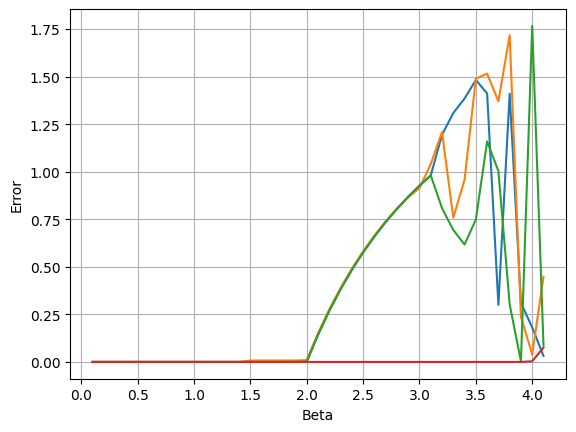

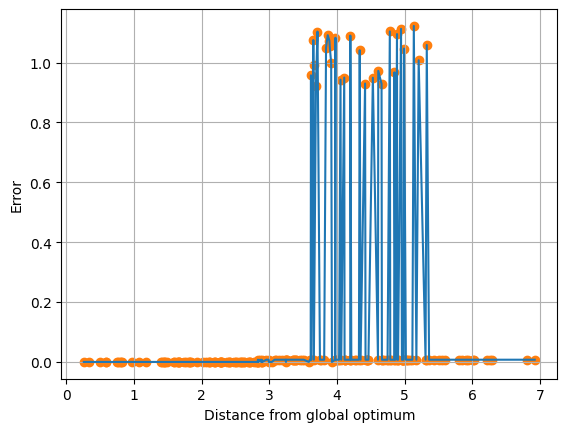

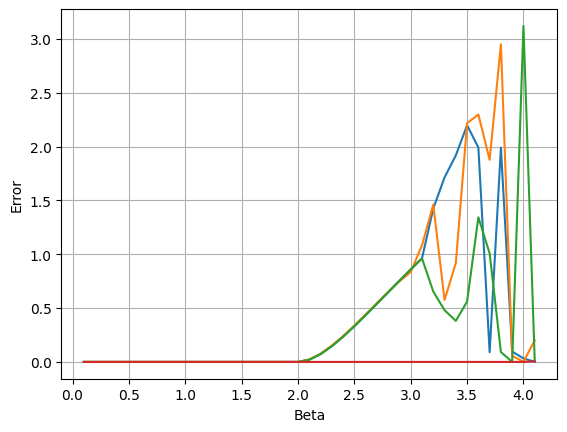

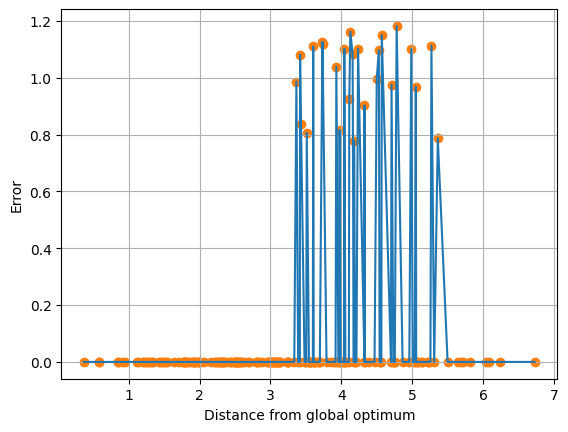

In [109]:
dimensions = DIMENSIONS
COUNT = 200
show_plots = True


bounds = [-5.0, 5.0]
iterations = 500

step = 0.1
domain = 4
epsilon = 10**(-11)

beta_init = 1.4
x_init = [
    [-0.4, 1.0],
    [0.7, -2.9],
    [1.5, 2.2],
    [0.0, 4.0]
]
distribution_bound = bounds[1]


test_func = Griewank(bounds, DIMENSIONS, beta=None, initial_position=None)
current_experiment = Experiment(test_func, iterations, step, domain, epsilon, show_plots)
G_beta_L1 = current_experiment.beta_experiment(x_init)
G_dist_L1 = current_experiment.initial_position_experiment(COUNT, beta_init, distribution_bound)
G_beta_MSE = current_experiment.beta_experiment(x_init, MSE=True)
G_dist_MSE = current_experiment.initial_position_experiment(COUNT, beta_init, distribution_bound, MSE=True)


## 1.2 Rastrigin

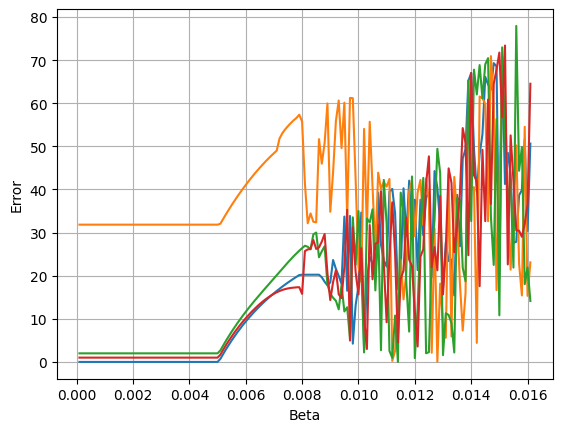

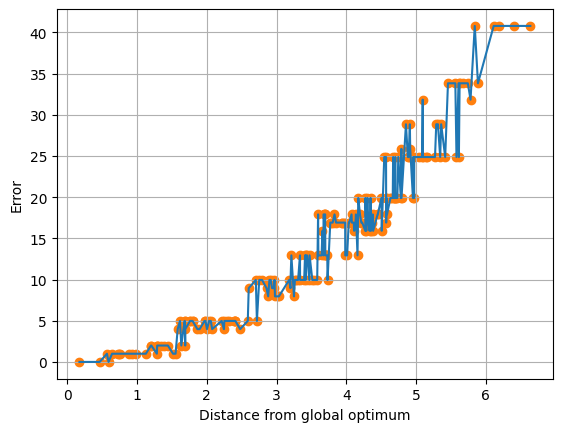

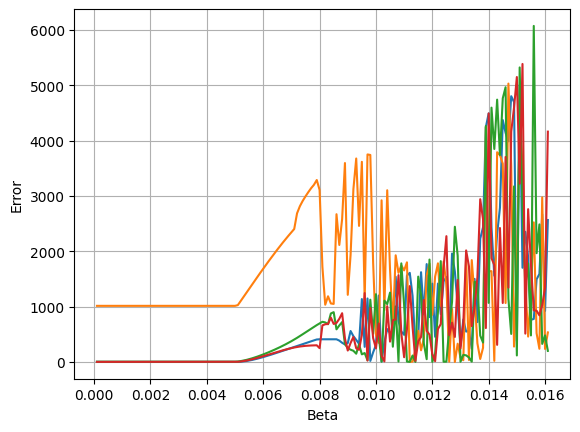

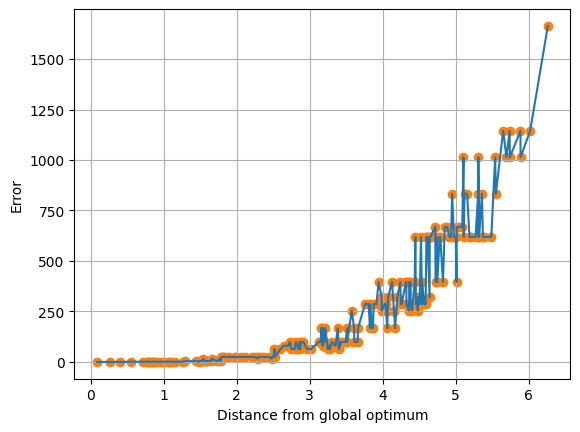

In [110]:
dimensions = DIMENSIONS
COUNT = 200
show_plots = True


bounds = [-5.12, 5.12]
iterations = 500

step = 0.0001
domain = 0.016
epsilon = 10**(-11)

beta_init = 0.004
x_init = [
    [-0.1, 0.2],
    [-4.3, -4.3],
    [-1.0, -1.0],
    [1.5, 0.5]
]
distribution_bound = bounds[1]

test_func = Rastrigin(bounds, DIMENSIONS, beta=None, initial_position=None)
current_experiment = Experiment(test_func, iterations, step, domain, epsilon, show_plots)
R_beta_L1 = current_experiment.beta_experiment(x_init)
R_dist_L1 = current_experiment.initial_position_experiment(COUNT, beta_init, distribution_bound)
R_beta_MSE = current_experiment.beta_experiment(x_init, MSE=True)
R_dist_MSE = current_experiment.initial_position_experiment(COUNT, beta_init, distribution_bound, MSE=True)

## 2 PRZYKŁADOWE TRAJEKTORIE

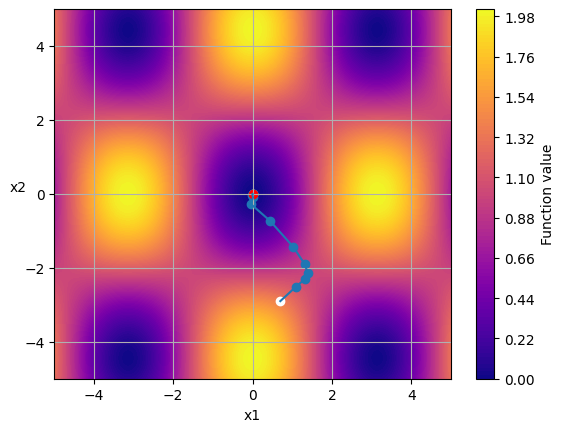

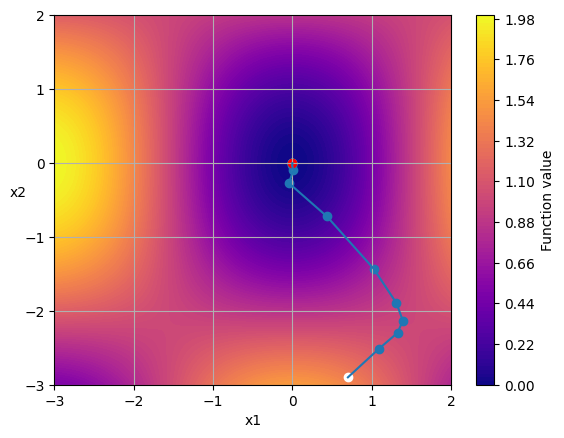

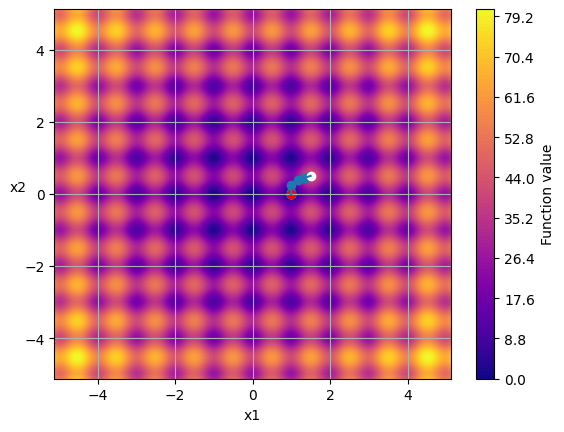

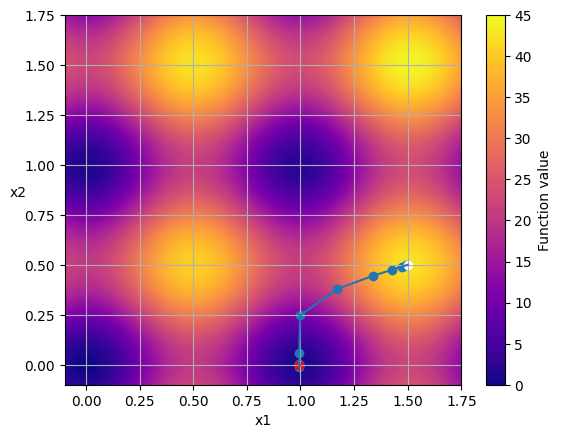

In [114]:
STEPS = 500


## Griewank:

bound = 5.0
gbounds = [-bound, bound]
x_init = [0.7, -2.9]
beta = 1.3

function = Griewank(gbounds, DIMENSIONS, beta, x_init)
test = Test(50, function)
route_x, route_y, route_q = test.do_test()
plot = Plotter(DIMENSIONS, STEPS, test.function(), bounds=None)
plot.plot(route_x, route_y)
close_plot = Plotter(DIMENSIONS, STEPS, test.function(), bounds=[-3, 2])
close_plot.plot(route_x, route_y)


## Rastrigin:

bound = 5.12
rbounds = [-bound, bound]
x_init = [1.5, 0.5]
beta = 0.003

function = Rastrigin(rbounds, DIMENSIONS, beta, x_init)
test = Test(50, function)
route_x, route_y, route_q = test.do_test()
plot = Plotter(DIMENSIONS, STEPS, test.function(), bounds=None)
plot.plot(route_x, route_y)
close_plot = Plotter(DIMENSIONS, STEPS, test.function(), bounds=[-0.1, 1.75])
close_plot.plot(route_x, route_y)


## 3 FUNKCJA KWADRATOWA

In [112]:
class Quadratic(Function):

    def __init__(self, bounds, dimensions, beta, initial_position, global_optimum=0):
        super().__init__(bounds, dimensions, beta, initial_position, global_optimum)
        self._name = "Quadratic"


    def q(self, x_vector):
        d = self._dimensions

        cost = 0
        for i in range(d):
            cost += (x_vector[i])**2

        return cost


    def grad(self, x_vector, i):
        x = x_vector[i]
        gradient = 2*x
        return gradient

### Testy zbieżności dla funkcji kwadratowej

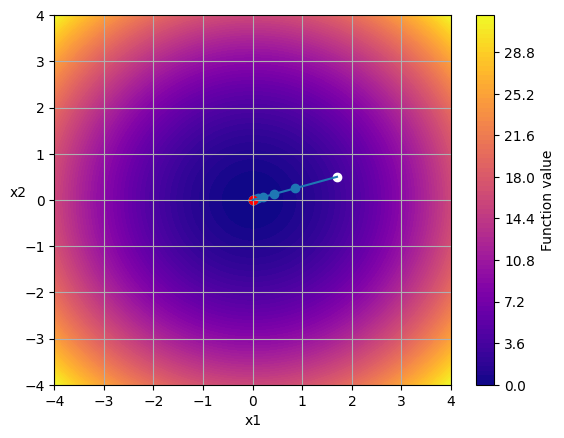

In [138]:
dimensions = DIMENSIONS
COUNT = 200
STEPS = 500
show_plots = True

bounds = [-4.0, 4.0]
x_init = [1.7, 0.5]
beta = 0.25


function = Quadratic(bounds, DIMENSIONS, beta=beta, initial_position=x_init)
test = Test(800, function)
route_x, route_y, route_q = test.do_test()
plot = Plotter(DIMENSIONS, STEPS, test.function(), bounds=bounds)
plot.plot(route_x, route_y)
